# this notebook tries to validate the thermal model
# start from 3C, high Dx DD only

In [40]:
# magic lines that avoid re-start
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
import pybamm;import numpy as np;import os;import matplotlib.pyplot as plt;import os;#import imageio
from scipy.io import savemat,loadmat;from pybamm import constants,exp,sqrt;
import matplotlib as mpl; 
fs=17; # or we can set import matplotlib.pyplot as plt then say 'mpl.rc...'
import openpyxl
import traceback
import multiprocessing;import pandas as pd   ;
font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)

In [42]:
import sys  
str_path_0 = os.path.abspath(os.path.join(pybamm.__path__[0],'..'))
str_path_1 = os.path.abspath(os.path.join(str_path_0,"wip\Rio_Code\Fun_P3"))
sys.path.append(str_path_1) 
from Fun_P3 import *
BasicPath = "D:/OneDrive - Imperial College London/SimDataSave/P3R13/"  #'D:/OneDrive - Imperial College London/SimDataSave/P3R13/'; 
Target  = 'Validation/' 
if not os.path.exists(BasicPath + Target):
   os.mkdir(BasicPath + Target)

In [43]:
# Define 3 models: normal DFN, single transport by high Dec, double transport
Model_DFN  = pybamm.lithium_ion.DFN(options={
    "solvent diffusion": "single no consume wo refill",
    "electrolyte conductivity": "full"  ,
    "thermal": "lumped"}) 
Model_DD  = pybamm.lithium_ion.DFN(options={
    "solvent diffusion": "double spatial consume w refill",
    "electrolyte conductivity": "sol full"  ,
    "thermal": "lumped"}) 
Model_All =[  Model_DD ] #  Model_DFN, 
Str_model =[  'Model_DD' ]
Para_All = []
for i in range(0,2):
    para=pybamm.ParameterValues("Li2023_ECdrag")
    para.update({"EC initial concentration in electrolyte [mol.m-3]":3500})
    para.update({"Typical EC concentration [mol.m-3]":3500})
    #para.update({"Background solvent concentration [mol.m-3]":7000})
    #para.update({"Negative electrode diffusivity [m2.s-1]":3.3e-14})
    #para.update({"Positive electrode diffusivity [m2.s-1]":4e-15})
    para.update({"Initial inner SEI thickness [m]":1e-8})
    para.update({"Initial outer SEI thickness [m]":1e-8})
    para.update({"Negative electrode porosity":0.20})
    Para_All.append(para)
# Landesf - high Dx; 
Para_All[0].update({"EC Lithium ion cross diffusivity [m2.s-1]":Cross_diffusivity_1p5E_10})
Para_All[0].update({"Cation transference number":electrolyte_transference_number_EC_EMC_3_7_Landesfeind2019_Con})
Para_All[0].update({"Electrolyte conductivity [S.m-1]":electrolyte_conductivity_EC_EMC_3_7_Landesfeind2019_Con})
Para_All[0].update({"Electrolyte diffusivity [m2.s-1]":electrolyte_diffusivity_EC_EMC_3_7_Landesfeind2019_Con})
# Landesf - low Dx; 
Para_All[1].update({"EC Lithium ion cross diffusivity [m2.s-1]":Cross_diffusivity_1p5E_12})
Para_All[1].update({"Cation transference number":electrolyte_transference_number_EC_EMC_3_7_Landesfeind2019_Con})
Para_All[1].update({"Electrolyte conductivity [S.m-1]":electrolyte_conductivity_EC_EMC_3_7_Landesfeind2019_Con})
Para_All[1].update({"Electrolyte diffusivity [m2.s-1]":electrolyte_diffusivity_EC_EMC_3_7_Landesfeind2019_Con})

Str_para = ['Landesf-H Dx', 'Landesf-L Dx',]
var_pts = {
    "x_n": 10,  # negative electrode
    "x_s": 5,  # separator 
    "x_p": 10,  # positive electrode
    "r_n": 60,  # negative particle
    "r_p": 30,  # positive particle
}

In [44]:
# all parameter: 2*2*4*2 = 32
TDF_Dis_All = [];Rate_Dis_All = [1,3, ];  Rate_Cha_All = [1 ];
k=0
for i in range(0,1):
    TDF_i_All = []; para = Para_All[i]; str_para = Str_para[i];
    for model,str_model in zip(Model_All,Str_model):
        TDF_i_All.append(
            Scan_Crate(Rate_Dis_All,Rate_Cha_All,model,para,str_model,str_para,var_pts)
            )
        k += 1
        print(f"Doing {k} scan C rate")
    TDF_Dis_All.append(TDF_i_All)
    del TDF_i_All

At t = 0.00872081 and h = 8.41113e-019, the corrector convergence failed repeatedly or with |h| = hmin.


Finish one cycle


At t = 0.00408357 and h = 2.1649e-018, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.00408357 and h = 1.26542e-018, the corrector convergence failed repeatedly or with |h| = hmin.


Finish one cycle
Doing 1 scan C rate


In [45]:
# Read cell-1 and 2 from 0.5C to 4C - done by Ruihe, calanedar age aleady ~98.36% at 0.5C
# Read Cell-1 2.5C to 3C:
BasicPath = "D:/OneDrive - Imperial College London/SimDataSave/InputData/" 
Target = "Ruihe_newLGM50_Crate/"
Cell_1_2p5to3C = pd.read_csv(
    BasicPath + Target + "dicharge_2.5C_3C_ch_a_1_CA1.txt", #engine='python',
    encoding = "shift-jis",  skiprows = 1,
    sep ='\t', header=None)
Cell_1_2p5to3C.head()
newNames = [
    "time/s", "Ns","Ecell/V", "I/mA", 
    "(Q-Qo)/mA.h", "Temperature/ｰC", 
    "Q charge/mA.h","Q discharge/mA.h","R/Ohm"]
oldNames = np.arange(9).tolist()
Cell_1_2p5to3C=Cell_1_2p5to3C.rename(columns={i:j for i,j in zip(oldNames,newNames)})
Cell_1_2p5to3C.head()
# Get Cell-1 2.5C and 3C:
font = {'family' : 'DejaVu Sans','size'   : 14};   mpl.rc('font', **font)
Cell_1_2p5C = Cell_1_2p5to3C[(Cell_1_2p5to3C['Ns']==5)]
df_dc4 = Cell_1_2p5to3C[(Cell_1_2p5to3C['Ns']==12)]
Cell_1_3C = Cell_1_2p5to3C[(Cell_1_2p5to3C['Ns']==12)]
# Read Cell-2 2.5C to 3C:
Cell_2_2p5to3C = pd.read_csv(
    BasicPath + Target + "dicharge_2.5C_3C_ch_a_2_CA2.txt", #engine='python',
    encoding = "shift-jis",  skiprows = 1,
    sep ='\t', header=None)
Cell_2_2p5to3C.head()
newNames = [
    "time/s", "Ns","Ecell/V", "I/mA", 
    "(Q-Qo)/mA.h", "Temperature/ｰC", 
    "Q charge/mA.h","Q discharge/mA.h","R/Ohm"]
oldNames = np.arange(9).tolist()
Cell_2_2p5to3C=Cell_2_2p5to3C.rename(columns={i:j for i,j in zip(oldNames,newNames)})
Cell_2_2p5to3C.head()
Cell_2_2p5C = Cell_2_2p5to3C[(Cell_2_2p5to3C['Ns']==5)]
df_dc4 = Cell_2_2p5to3C[(Cell_2_2p5to3C['Ns']==12)]
Cell_2_3C = Cell_2_2p5to3C[(Cell_2_2p5to3C['Ns']==12)]
# Read Cell-1 3.5C to 4C:
Cell_1_3p5to4C = pd.read_csv(
    BasicPath + Target + "Discharge_test_3p5_to_4C_A1_CA1.txt", #engine='python',
    encoding = "shift-jis",  skiprows = 1,
    sep ='\t', header=None)
Cell_1_3p5to4C.head()
newNames = [
    "time/s", "Ns","Ecell/V", "I/mA", 
    "(Q-Qo)/mA.h", "Temperature/ｰC", 
    "Q charge/mA.h","Q discharge/mA.h","R/Ohm"]
oldNames = np.arange(9).tolist()
Cell_1_3p5to4C=Cell_1_3p5to4C.rename(columns={i:j for i,j in zip(oldNames,newNames)})
Cell_1_3p5to4C.head()
Cell_1_3p5C = Cell_1_3p5to4C[(Cell_1_3p5to4C['Ns']==5)]
df_dc4 = Cell_1_3p5to4C[(Cell_1_3p5to4C['Ns']==12)]
Cell_1_4C = Cell_1_3p5to4C[(Cell_1_3p5to4C['Ns']==12)]
# Read Cell-2 3.5C to 4C:
Cell_2_3p5to4C = pd.read_csv(
    BasicPath + Target + "Discharge_test_3p5_to_4C_A2_CA3.txt", #engine='python',
    encoding = "shift-jis",  skiprows = 1,
    sep ='\t', header=None)
Cell_2_3p5to4C.head()
newNames = [
    "time/s", "Ns","Ecell/V", "I/mA", 
    "(Q-Qo)/mA.h", "Temperature/ｰC", 
    "Q charge/mA.h","Q discharge/mA.h","R/Ohm"]
oldNames = np.arange(9).tolist()
Cell_2_3p5to4C=Cell_2_3p5to4C.rename(columns={i:j for i,j in zip(oldNames,newNames)})
Cell_2_3p5to4C.head()
Cell_2_3p5C = Cell_2_3p5to4C[(Cell_2_3p5to4C['Ns']==5)]
df_dc4 = Cell_2_3p5to4C[(Cell_2_3p5to4C['Ns']==12)]
Cell_2_4C = Cell_2_3p5to4C[(Cell_2_3p5to4C['Ns']==12)]
# Read Cell-2 up to 2C:
Cell_2_UpTo2C = pd.read_csv(
    BasicPath + Target + "dicharge_to_2C_ch_a_2_CA2.txt", #engine='python',
    encoding = "shift-jis",  skiprows = 1,
    sep ='\t', header=None)
Cell_2_UpTo2C.head()
newNames = [
    "time/s", "Ns","Ecell/V", "I/mA", 
    "(Q-Qo)/mA.h", "Temperature/ｰC", 
    "Q charge/mA.h","Q discharge/mA.h","R/Ohm"]
oldNames = np.arange(9).tolist()
Cell_2_UpTo2C=Cell_2_UpTo2C.rename(columns={i:j for i,j in zip(oldNames,newNames)})
Cell_2_UpTo2C.head()

Cell_2_0p5C = Cell_2_UpTo2C[(Cell_2_UpTo2C['Ns']==5)]
Cell_2_1C = Cell_2_UpTo2C[(Cell_2_UpTo2C['Ns']==12)]
Cell_2_1p25C = Cell_2_UpTo2C[(Cell_2_UpTo2C['Ns']==19)]
Cell_2_1p5C = Cell_2_UpTo2C[(Cell_2_UpTo2C['Ns']==26)]
Cell_2_1p75C = Cell_2_UpTo2C[(Cell_2_UpTo2C['Ns']==33)]
Cell_2_2C = Cell_2_UpTo2C[(Cell_2_UpTo2C['Ns']==40)]
# Read Cell-1 up to 2C:

Cell_1_UpTo2C = pd.read_csv(
    BasicPath + Target + "dicharge_to_2C_ch_a_1_CA1.txt", #engine='python',
    encoding = "shift-jis",  skiprows = 1,
    sep ='\t', header=None)
Cell_1_UpTo2C.head()
newNames = [
    "time/s", "Ns","Ecell/V", "I/mA", 
    "(Q-Qo)/mA.h", "Temperature/ｰC", 
    "Q charge/mA.h","Q discharge/mA.h","R/Ohm"]
oldNames = np.arange(9).tolist()
Cell_1_UpTo2C=Cell_1_UpTo2C.rename(columns={i:j for i,j in zip(oldNames,newNames)})
Cell_1_UpTo2C.head()

Cell_1_0p5C = Cell_1_UpTo2C[(Cell_1_UpTo2C['Ns']==5)]
Cell_1_1C = Cell_1_UpTo2C[(Cell_1_UpTo2C['Ns']==12)]
Cell_1_1p25C = Cell_1_UpTo2C[(Cell_1_UpTo2C['Ns']==19)]
Cell_1_1p5C = Cell_1_UpTo2C[(Cell_1_UpTo2C['Ns']==26)]
Cell_1_1p75C = Cell_1_UpTo2C[(Cell_1_UpTo2C['Ns']==33)]
Cell_1_2C = Cell_1_UpTo2C[(Cell_1_UpTo2C['Ns']==40)]
# collect all together
Cell_2_All = [
    Cell_2_0p5C,Cell_2_1C,Cell_2_1p25C,Cell_2_1p5C,Cell_2_1p75C,
    Cell_2_2C,Cell_2_2p5C,Cell_2_3C,Cell_2_3p5C,Cell_2_4C];
Cell_1_All = [
    Cell_1_0p5C,Cell_1_1C,Cell_1_1p25C,Cell_1_1p5C,Cell_1_1p75C,
    Cell_1_2C,Cell_1_2p5C,Cell_1_3C,Cell_1_3p5C,Cell_1_4C];
str_Crate = ["0.5","1","1.25","1.5","1.75","2","2.5","3","3.5","4",]

In [ ]:
# Summarize Exp - plot temperature rise and capacity vs C rate


Text(0.5, 0, 'Time [s]')

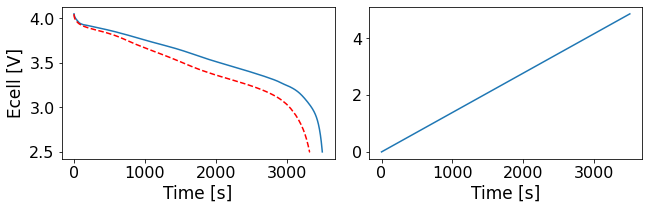

In [51]:
# str_Crate = ["0.5","1","1.25","1.5","1.75","2","2.5","3","3.5","4",]
# single high Dx: TDF_Dis_All[0][0] low Dx: TDF_Dis_All[1][0]     
# double high Dx: TDF_Dis_All[0][1] low Dx: TDF_Dis_All[1][1]   
Colors = ['#1f77b4','#2ca02c',  '#d62728', '#ff7f0e'];
font = {'family' : 'DejaVu Sans','size'   : 16}
mpl.rc('font', **font)
Crate_index = 0;   
LS = ['-','--','-','--'];
fig, axs = plt.subplots(1,2, figsize=(9.3,3.2),tight_layout=True)
for i in range(1):
    for j in range(1):
        sol = TDF_Dis_All[i][j]['MyDict_All'][Crate_index]['Solution']
        step =  sol.cycles[0].steps[1]
        axs[0].plot(
            step['Time [s]'].entries-step['Time [s]'].entries[0], 
            step["Terminal voltage [V]"].entries,
            color=Colors[0],linestyle=LS[0],label=r"Single-High $D_\times$") 
        axs[1].plot(
            step['Time [s]'].entries-step['Time [s]'].entries[0], 
            step["Discharge capacity [A.h]"].entries-step["Discharge capacity [A.h]"].entries[0],
            color=Colors[0],linestyle=LS[0],label=r"Single-High $D_\times$") 
# str_Crate = ["0.5","1","1.25","1.5","1.75","2","2.5","3","3.5","4",]
i=1
axs[0].plot(
    (Cell_1_All[i]["time/s"]-Cell_1_All[i]["time/s"].iloc[0])/1,
    Cell_1_All[i]["Ecell/V"],linestyle='--',
    color="r",label=f"{str_Crate[i]} C")

axs[0].set_ylabel("Ecell [V]",fontsize=fs)
axs[1].set_xlabel("Time [s]",fontsize=fs)
axs[0].set_xlabel("Time [s]",fontsize=fs)

#plt.savefig(BasicPath + Target+"Fig. 2 - 3C discharge vol decompos.png", dpi=800)

In [47]:
temp = step["Discharge capacity [A.h]"].entries-step["Discharge capacity [A.h]"].entries[0]
print(temp[-1])
i=1
Cell_1_All[i]["Q discharge/mA.h"].iloc[-1]/1e3

4.86458787160754


4.61212736701687

Text(0.5, 0, 'Time [s]')

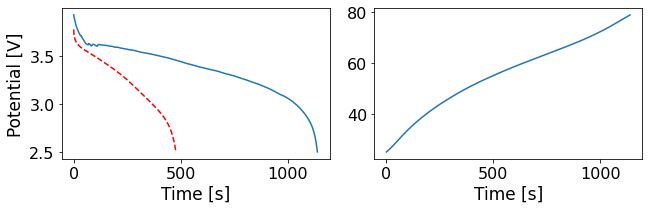

In [52]:
# str_Crate = ["0.5","1","1.25","1.5","1.75","2","2.5","3","3.5","4",]
# single high Dx: TDF_Dis_All[0][0] low Dx: TDF_Dis_All[1][0]     
# double high Dx: TDF_Dis_All[0][1] low Dx: TDF_Dis_All[1][1]   
Colors = ['#1f77b4','#2ca02c',  '#d62728', '#ff7f0e'];
font = {'family' : 'DejaVu Sans','size'   : 16}
mpl.rc('font', **font)
Crate_index = 1;   
LS = ['-','--','-','--'];
fig, axs = plt.subplots(1,2, figsize=(9.3,3.2),tight_layout=True)
for i in range(1):
    for j in range(1):
        sol = TDF_Dis_All[i][j]['MyDict_All'][Crate_index]['Solution']
        step =  sol.cycles[0].steps[1]
        axs[0].plot(
            step['Time [s]'].entries-step['Time [s]'].entries[0], 
            step["Terminal voltage [V]"].entries,
            color=Colors[0],linestyle=LS[0],label=r"Single-High $D_\times$") 
        axs[1].plot(
            step['Time [s]'].entries-step['Time [s]'].entries[0], 
            #step["Discharge capacity [A.h]"].entries-step["Discharge capacity [A.h]"].entries[0],
            step["Volume-averaged cell temperature [C]"].entries ,
            color=Colors[0],linestyle=LS[0],label=r"Single-High $D_\times$") 
# str_Crate = ["0.5","1","1.25","1.5","1.75","2","2.5","3","3.5","4",]
i=7
axs[0].plot(
    (Cell_1_All[i]["time/s"]-Cell_1_All[i]["time/s"].iloc[0])/1,
    Cell_1_All[i]["Ecell/V"],linestyle='--',
    color="r",label=f"{str_Crate[i]} C")

axs[0].set_ylabel("Potential [V]",fontsize=fs)
axs[1].set_xlabel("Time [s]",fontsize=fs)
axs[0].set_xlabel("Time [s]",fontsize=fs)

#plt.savefig(BasicPath + Target+"Fig. 2 - 3C discharge vol decompos.png", dpi=800)

In [49]:
model.variables.search("Temperature")

Ambient temperature
Ambient temperature [C]
Ambient temperature [K]
Cell temperature
Cell temperature [C]
Cell temperature [K]
Negative current collector temperature
Negative current collector temperature [C]
Negative current collector temperature [K]
Negative electrode temperature
Negative electrode temperature [C]
Negative electrode temperature [K]
Positive current collector temperature
Positive current collector temperature [C]
Positive current collector temperature [K]
Positive electrode temperature
Positive electrode temperature [C]
Positive electrode temperature [K]
Separator temperature
Separator temperature [C]
Separator temperature [K]
Volume-averaged cell temperature
Volume-averaged cell temperature [C]
Volume-averaged cell temperature [K]
X-averaged cell temperature
X-averaged cell temperature [C]
X-averaged cell temperature [K]
X-averaged negative electrode temperature
X-averaged negative electrode temperature [C]
X-averaged negative electrode temperature [K]
X-averaged pos

In [50]:
print(step["Current [A]"].entries[-1])
print(Cell_1_All[i]["I/mA"].iloc[0]/1E3)

15.0
-14.983243
